In [3]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
import sklearn
import mglearn
from IPython.display import display
import matplotlib.pyplot as plt

## 3.5.2 병합 군집

병합 군집은 시작할 때 각 포인트를 하나의 클러스터로 지정하고, 그다음 어떤 종료 조건을 만족할 때까지 가장 비슷한 두 클러스터를 합쳐나가는 원리로 이루어진 군집 알고리즘들을 말한다. 사이킷런에서는 클러스터 개수가 종료 조건이다

**linkage 옵션: 가장 비슷한 클러스터를 측정하는 방법**

- ward: 모든 클러스터 내의 분산을 가장 작게 증가시키는 두 클러스터를 합침

- average: 클러스터 포인트 사이의 평균 거리가 가장 짧은 두 클러스터를 합침

- complete: 클러스터 포인트 사이의 최대 거리가 가장 짧은 두 클러스터를 합침

대부분의 데이터셋은 ward가 알맞고 아래에서도 ward를 사용

아래는 2차원 데이터셋에서 세 개의 클러스터를 찾기위한 병합 군집의 과정이다.

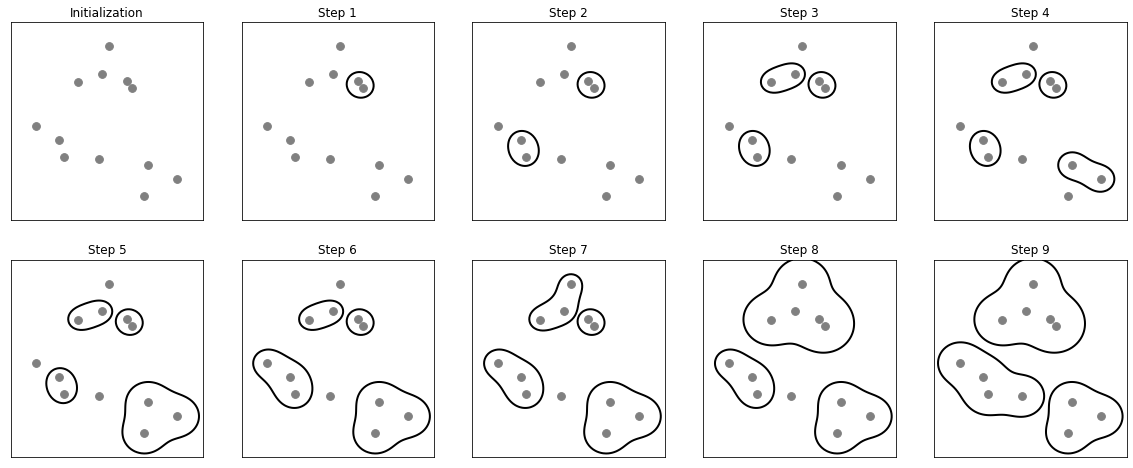

In [4]:
mglearn.plots.plot_agglomerative_algorithm()

포인터 = 클러스터로 시작하며 9단계를 거치니 3개의 클러스터로 수렴되며 종료 조건이 3개라면 여기서 멈춘다.

병합 군집은 새로운 데이터 포인트에 대해서는 예측을 할 수 없기에 predict 메서드를 사용할 수 없다. 그래서 fit_predict 메서드를 사용한다. 결과는 아래와 같다.

Text(0, 0.5, 'Feature 1')

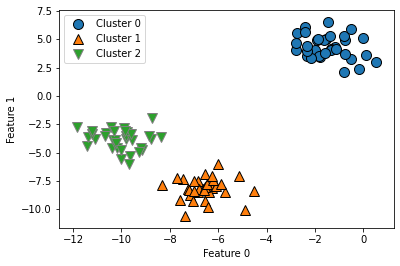

In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3) # 종료 조건
assignment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:, 0], X[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### 계층적 군집과 덴드로그램

병합 군집은 계층적 군집을 만든다. 처음부터 마지막 클러스터 까지의 클러스터들을 겹쳐서 표시하면 볼 수 있다. 클러스터가 어떻게 나뉘는지 볼 수 있다.

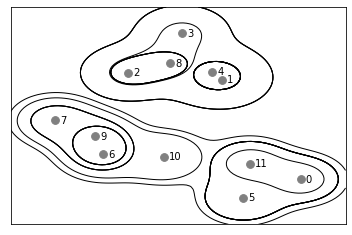

In [6]:
mglearn.plots.plot_agglomerative()

2차원이라 표현하기 쉬웠다. 하지만 특성이 셋 이상일 때는 계층적 군집으로는 표현하기 힘들다. 다른 도구인 덴드로그램은 다차원 데이터셋을 처리할 수 있다.

사이킷런에서는 지원하지 않기에 SciPy를 사용해서 덴드로그램 그래프를 그려보겠다.

Text(0, 0.5, 'Cluster distance')

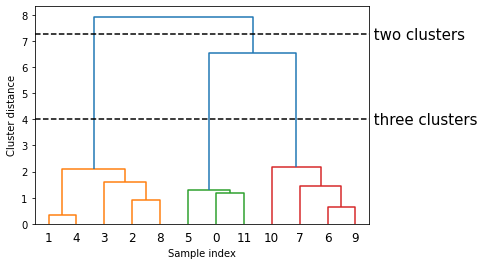

In [7]:
# SciPy에서 ward 군집 함수와 덴드로그램 함수를 임포트합니다.
from scipy.cluster.hierarchy import dendrogram, ward

X, y = make_blobs(random_state=0, n_samples=12)
# 데이터 배열 X에 ward 함수를 적용한다.
# SciPy의 ward 함수는 병합 군집을 수행할 때 생성된
# 거리 정보가 담긴 배열을 반환한다.
linkage_array = ward(X)
# 클러스터 간의 거리 정보가 담긴 linkage_array를 사용해 덴드로그램을 그립니다.
dendrogram(linkage_array)

# 두 개와 세 개의 클러스터를 구분하는 커트라인을 표시합니다.
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

클러스터들이 합쳐지며 부모 노드가 만들어지고 y축은 합쳐진 클러스터가 얼마나 멀리 떨어져있는지를 보여준다.

하지만 병합 군집은 two_moons 데이터셋과 같은 복잡한 형상을 구분하지 못한다.

## 3.5.3 DBSCAN

군집 알고리즘이며 주요 장점은 클러스터의 개수를 미리 지정할 필요가 없는 것이다. 복잡한 형상 가능, 어떤 클래스에도 속하지 않는 포인트 구분 가능.

병합 군집이나 k-평균보다는 느리지만 비교적 큰 데이터셋에도 적용 가능.

아이디어: 밀집 지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분 됨. 

- eps: 한 데이터 포인트 주변의 거리 매개변수

- min_samples: 핵심 샘플로 분류할 eps 거리 안의 데이터 포인트 개수의 매개변수

**진행 절차**
1. 무작위 포인터 선택 후 eps 거리 안의 모든 포인트를 찾으며 min_samples 개수보다 적게 존재한다면 노이즈 처리.
2. min_samples 보다 많으면 핵심 샘플로 레이블하고 새로운 클러스터 레이블 할당 후 eps 거리 안의 이웃을 살펴보고, 어떤 클러스터에도 할당되지 않았다면 바로 전에 만든 클러스터 레이블을 할당.
3. eps 거리 안의 모든 포인트들을 진행 후 방문하지 못한 포인트에 대해 같은 과정 반복.



In [8]:
from sklearn.cluster import DBSCAN
X, y = make_blobs(random_state=0, n_samples=12)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Cluster memberships:\n{}".format(clusters))

Cluster memberships:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


잡음 포인트를 의미하는 '-1'이 할당 되었는데 이 데이터셋에 적합하지 않은 매개변수를 사용했기 때문이다. 아래는 매개변수 변화에 따른 클러스터 할당이다.

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


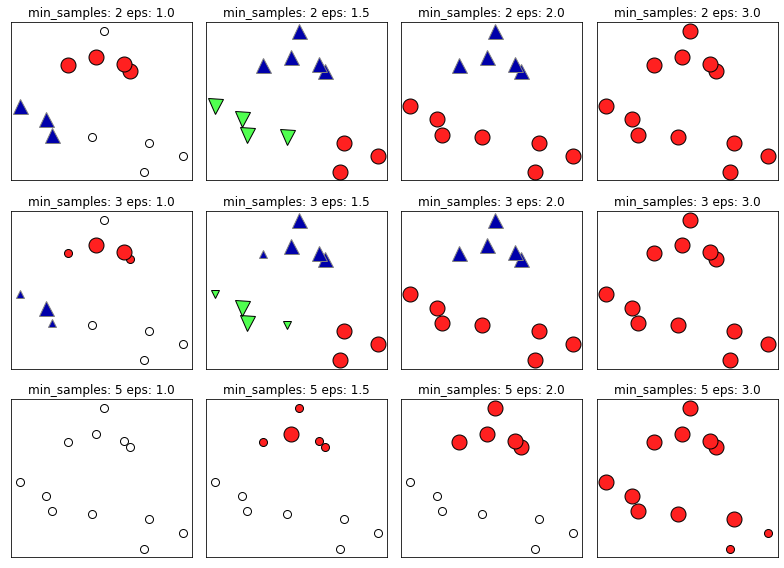

In [9]:
mglearn.plots.plot_dbscan()

하얀색: 잡음 포인트

큰거: 핵심 포인트

작은거: 경계 포인트

eps: 포인트 범위 조절

min_samples: 클러스터 최소 크기 조절

DBSCAN은 클러스터 개수를 지정할 필요는 없지만 eps가 간접적으로 제어하게 된다. 스케일링도 해주는게 좋다.

아래는 two_moons 데이터셋에 DBSCAN을 적용한 결과이다. 정확히 반달 모양을 구분했다.

Text(0, 0.5, 'Feature 1')

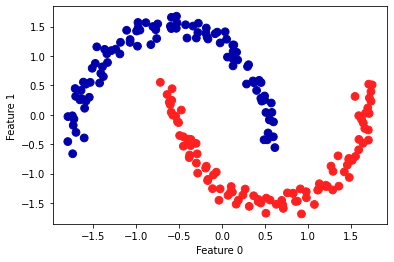

In [10]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균 0, 분산 1 되도록 데이터의 스케일을 조정
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
# 클러스터 할당을 표시
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## 3.5.4 군집 알고리즘의 비교와 평가

### 타깃값으로 군집 평가하기

ARI와 NMI라는 지표로 정답 클러스터와 비교하여 평가할 수 있다. 다음에서 ARI를 사용해서 k-평균, 병합 군집, DBSCAN 알고리즘을 비교하겠다.

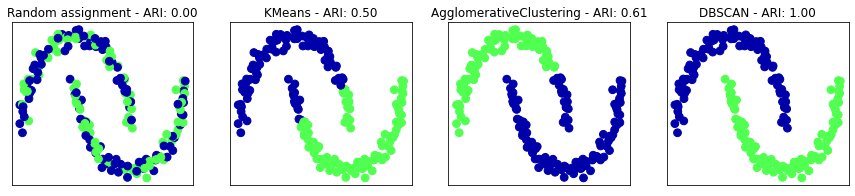

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균 0, 분산 1이 되도록 데이터의 스케일을 조정
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 사용할 알고리즘 모델을 리스트로 만듦
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# 비교를 위해 무작위로 클러스터 할당
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 무작위 할당한 클러스터 그림
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # 클러스터 할당과 클러스터 중심을 그림
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

ARI 점수는 1에 가까울 수록 최적인 것이며 0에 가까울 수록 무작위에 가깝다.

군집 모델을 평가할 때 흔히 하는 실수는 adjusted_rand_score나 normalized_mutual_info_score 같은 군집용 측정 도구를 사용하지 않고 accuray_score를 사용하는 것이다. 레이블 자체에 의미가 있는 것이 아니라 같은 클러스터에 속해있냐가 의미가 있는 것이기 때문이다.

In [12]:
from sklearn.metrics import accuracy_score

# 포인트가 클러스터로 나뉜 두 가지 경
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# 모든 레이블이 달라졌으므로 정확도는 0이다. 
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# 하지만 같은 포인트가 클러스터에 모였으므로 ARI는 1이다. 
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00


### 타깃값 없이 군집 평가하기

군집 알고리즘을 적용할 땨 보통 그 결과와 비교할 터깃값이 없다.

타깃값이 필요 없는 군집용 지표로 실루엣 계수가 있다. 클러스터의 밀집 정도를 계산하는 것으로 모델이 복잡할 때는 잘 들어맞지 않는다.

다음은 two_moons 데이터셋에서 실루엣 점수를 사용해 k-평균, 병합 군집, DBSCAN의  결과를 비교한 예이다.



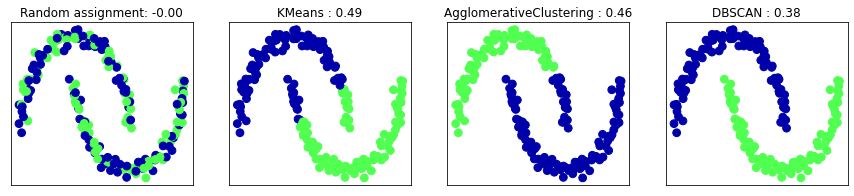

In [13]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균이 0, 분산이 1이 되도록 데이터의 스케일 조
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 비교를 위해 무작위로 클러스터 할당
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 무작위 할당한 클러스터 그리기
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # 클러스터 할당과 중심을 그린다.
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

DBSCAN의 결과가 좋지만 KMeans의 실루엣 점수가 더 높은 것을 볼 수 있는데 견고성 기반의 지표이기 떄문이다. 

군집 모델이 안정적이거나 실루엣 점수가 높다고 하더라도 군집에 어떤 유의미한 것이 있는지 또는 군집이 데이터의 흥미로운 면을 반영하고 있는지는 여전히 알 수 없다.

얼굴 데이터셋에 적용해보자

### 얼굴 데이터셋으로 군집 알고리즘 비교


PCA(white=True)로 생성한 100개의 주성분, 즉 고유 얼굴을 입력 데이터로 사용하겠다. 어떤 클러스터를 찾았는지 확인해 보자

In [14]:
# LFW 데이터에서 고유얼굴을 찾은 다음 데이터를 변환합니다.
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
pca = PCA(n_components=100, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_people)
X_people /= 255.

PCA 화이트닝 설정을 해주며 주성분으로 원본 픽셀보다 의미 있는 정보를 담고 있다.

In [15]:
# 기본 매개변수로 DBSCAN 적용 
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


-1 이라는 레이블뿐이므로 모든 데이터가 잡음 포인트로 할당 되었다. 이때 eps 값을 크게하거나 min_samples 값을 낮추면 된다.

min_samples를 먼저 해보자.

In [16]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


3으로 줄여도 모두 잡음 포인트로 레이블되었다.

eps를 키워보자

In [17]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


eps를 15로 크게 늘렸더니 클러스터 하나와 잡음 포인트를 얻었다. 잡음 포인트와 클러스터에 속한 포인트가 몇 개인지 알아보자

In [18]:
# 잡음 포인트와 클러스터에 속한 포인트 수를 셉니다.
# bincount는 음수를 받을 수 없어서 labels에 1을 더한다.
# 반환값의 첫 번째 원소는 잡음 포인트의 수이다.
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  32 2031]


잡음 포인트는 32개로 많지 않으니 모두 확인해볼 수 있다. 촬영 거리, 각도, 장애물 등 여러가지 원인으로 인해서 잡음으로 분류된걸로 추론할 수 있다.

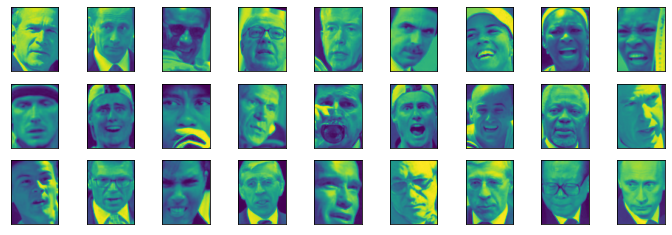

In [19]:
noise = X_people[labels==-1]
image_shape = people.images[0].shape
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)


위 처럼 특이한 것을 찾아내는 종류의 분석을 '이상치 검출'이라고 한다.

큰 클러스터 하나보다 더 많은 클러스터를 찾으려면 eps를 0.5~15 사이로 출여야 한다. 다음은 eps 값에 따른 차이를 살펴보겠다.

In [20]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Number of clusters: 1
Cluster sizes: [2063]

eps=3
Number of clusters: 1
Cluster sizes: [2063]

eps=5
Number of clusters: 1
Cluster sizes: [2063]

eps=7
Number of clusters: 14
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
Number of clusters: 4
Cluster sizes: [1307  750    3    3]

eps=11
Number of clusters: 2
Cluster sizes: [ 413 1650]

eps=13
Number of clusters: 2
Cluster sizes: [ 120 1943]


너무 작으면 잡음으로 처리되며 eps가 커질수록 클러스터가 많아지다가 하나의 큰 클러스터와 나머지가 구성된다. 

아래에선 작은 클러스터가 많이 만들어진 eps=7일 때, 13개 클러스터에 있는 모든 포인트를 시각화 해본 것이다.

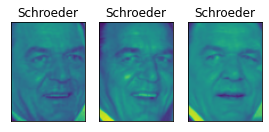

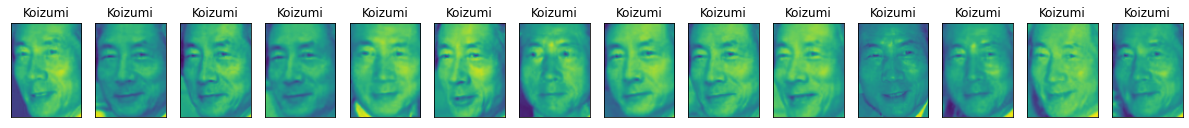

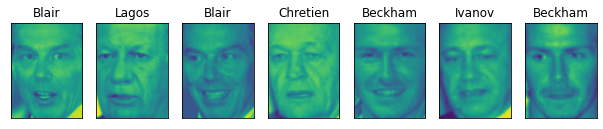

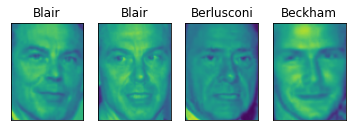

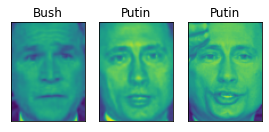

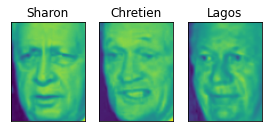

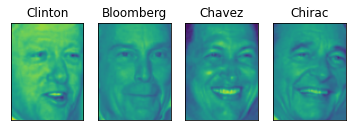

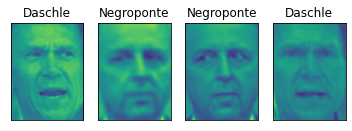

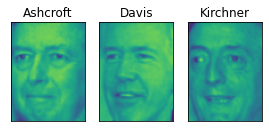

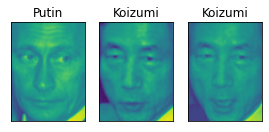

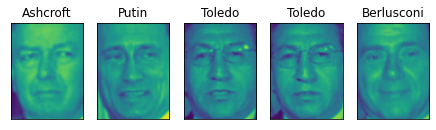

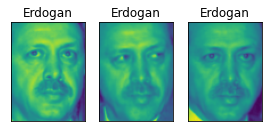

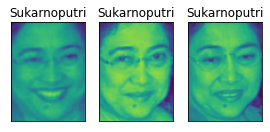

In [21]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images =  np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):

        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

같은 클러스터의 이미지들은 얼굴 표정과 각도가 거의 동일하다는 것을 볼 수 있다.

### k-평균으로 얼굴 데이터셋 분석하기

클러스터 개개를 분석해볼 수 있도록 클러스터 개수를 10 정도로 줄여서 적용해보자.

In [22]:
# k-평균으로 클러스터를 추출
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [280 226 104 268 152 326 203 208 207  89]


DBSCAN가 한 개의 큰 클러스터를 만드는 것과 달리 k-평균 군집은 비교적 비슷한 크기인 91~358까지의 클러스터로 나누었다.

다음은 k-평균 클러스터 중심을 시각화 해볼 것인데 PCA 성분으로 군집 알고리즘을 적용했기 때문에 pca.inverse_transform을 사용해 원본 공간으로 되돌린 후 시각화 해야한다.

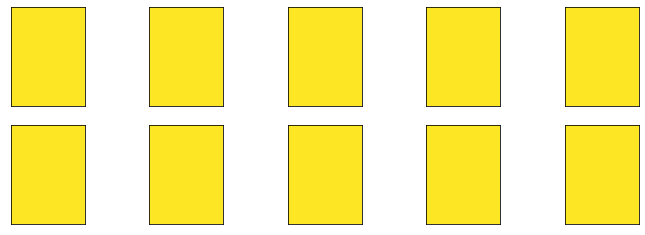

In [23]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),
              vmin=0, vmax=1)

k-평균이 찾은 클러스터 중심은 여러 이미지들의 평균이기 때문에 매우 부드러운 얼굴 이미지다.

좀 더 자세히 보기 위해서 각 클러스터에서 대표되는 이미지, 가장 동떨어진 이미지 각각 5개씩 나타내보겠다.

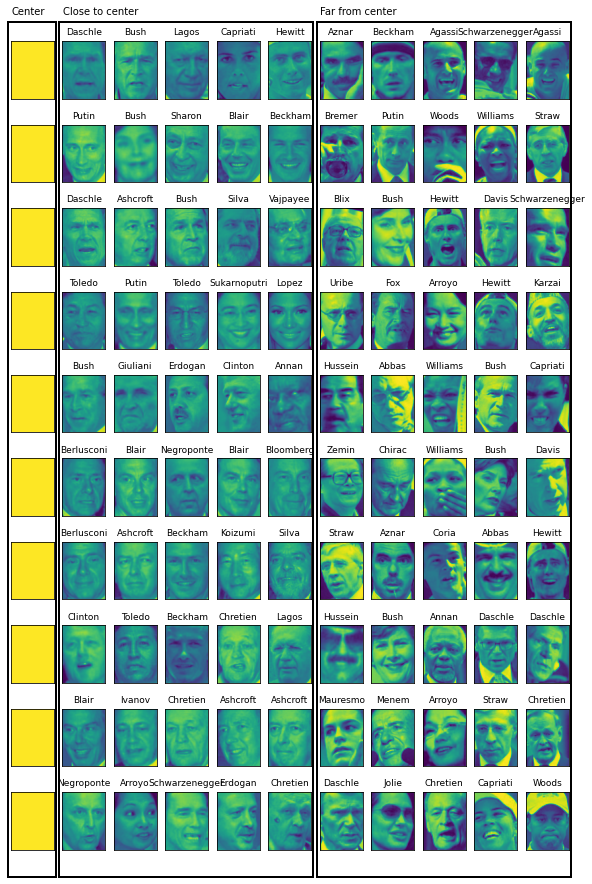

In [24]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people,
                                y_people, people.target_names)

세 번째 클러스터는 웃는 얼굴, 나머지 클러스터는 얼굴 각도를 중시한다. 중심에서 먼 포인트들은 중심과 많이 달라 보인다. 클러스터 수를 늘리면 미세한 차이를 더 찾을 수 있지만 그만큼 직접 조사하는 것이 더 힘들어진다.

### 병합 군집으로 웃는 얼굴 데이터셋 분석하기

병합 군집의 결과를 보니 DBSCAN과 비교하면 비교적 비슷한 크기인 18~660개 크기의 클러스터를 만듭니다.

In [25]:
# 병합 군집으로 클러스터를 추출합니다.
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(
       np.bincount(labels_agg)))

cluster sizes agglomerative clustering: [169 660 144 329 217  85  18 261  31 149]


ARI 점수를 이용해 병합 군집과 k-평균으로 만든 두 데이터가 비슷한지 측정해보겠다.

In [26]:
print("ARI: {:.2f}".format(adjusted_rand_score(labels_agg, labels_km)))

ARI: 0.10


두 군집 사이에는 공통 부분이 거의 없는 수준이다. 

이제 덴드로그램을 트리 깊이를 제한하고 그려보겠다.

Text(0, 0.5, 'Cluster distance')

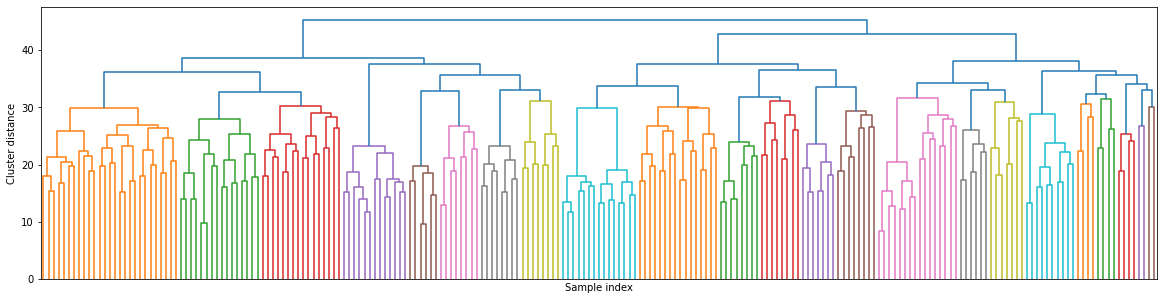

In [27]:
linkage_array = ward(X_pca)
# 클러스터 사이의 거리가 담겨 있는 linkage_array로 덴드로그램을 그립니다.
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

가지의 길이를 보고 데이터를 나눌 수 있는데 어떤 가지는 잘 구분했고 어떤 가지는 잘 구분하지 못한 것으로 보인다.

10개의 각 클러스터에 속한 몇 개의 포인트를 나타내보겠다.

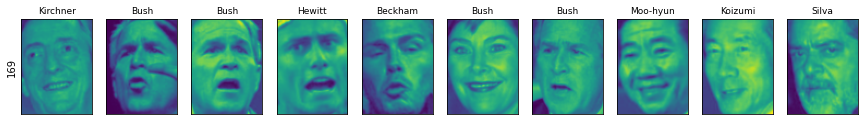

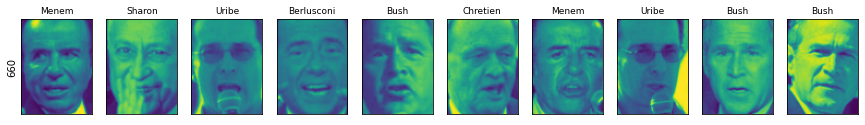

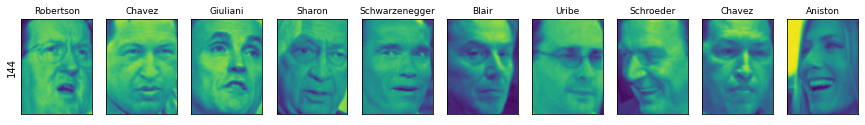

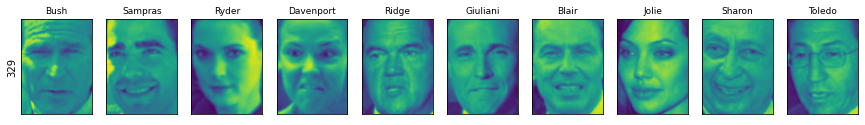

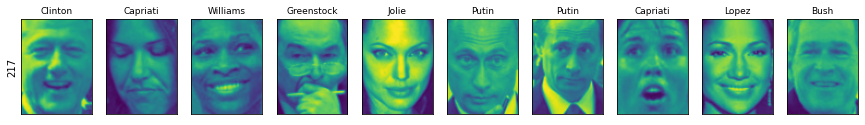

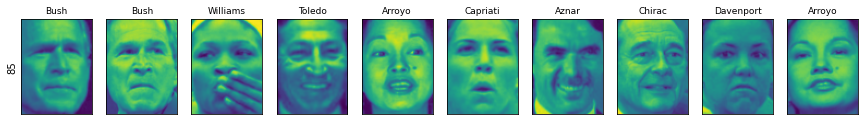

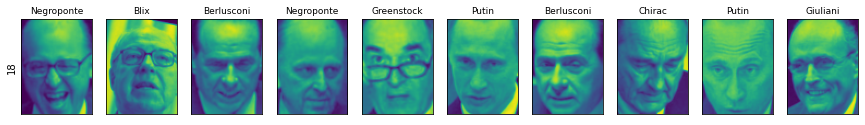

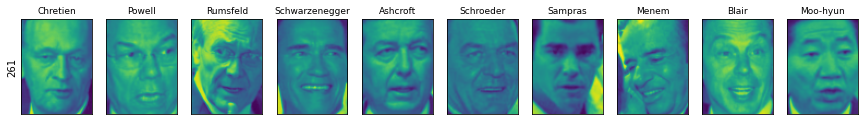

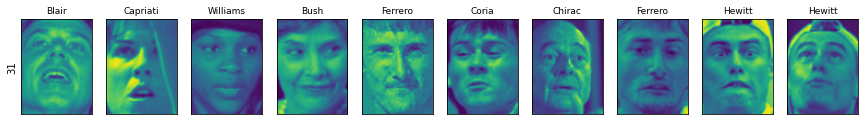

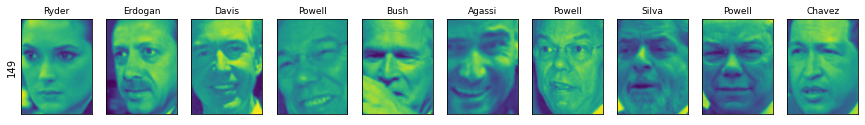

In [28]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                      labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
                     fontdict={'fontsize': 9})

일관성을 가지기엔 너무 큰 클러스터들이 존재하기에 40개의 클러스터로 알고리즘을 다시 실행하자.

cluster sizes agglomerative clustering: [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


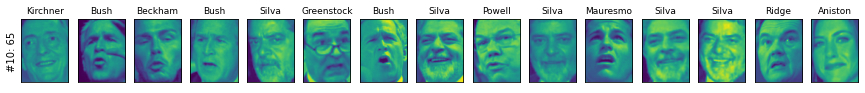

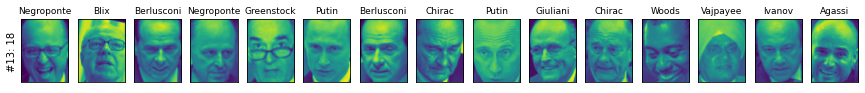

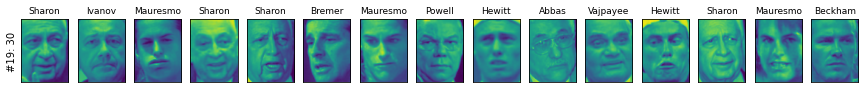

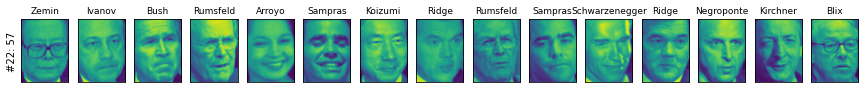

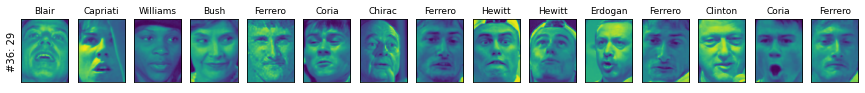

In [29]:
# 병합 군집으로 글러스터를 추출합니다.
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                      labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
                     fontdict={'fontsize': 9})
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)